# Using Lowess Regression in openEO for Filling Missing Time Series Data

Time series data exhibits gaps or missing values in numerous scenarios, often attributed to factors like cloud cover. It becomes imperative to address these gaps to ensure the completeness of datasets. In statistical analysis, various tools are available for filling in such missing values, and herein, we employ one such tool. This notebook attempts to mitigate these gaps in our time series data using a regression technique, specifically the Lowess model.

Lowess, an acronym for Locally Weighted Scatterplot Smoothing, constitutes a robust, non-parametric method that employs locally weighted regression to fit a smooth curve through data points. This method offers a versatile approach to discern patterns and relationships within the data. The fundamental principle behind Lowess involves fitting simple models to localized subsets of the data, thereby constructing a function that captures the underlying structure. Widely utilized in exploratory data analysis, Lowess facilitates the visualization of trends and patterns.

In this context, we implement Lowess smoothing directly within the openEO User-Defined Function (UDF). Given the objective of showcasing the integration of such models into the openEO workflow, this notebook mainly focuses on presentation rather than model finetuning.

References:
* https://en.wikipedia.org/wiki/Local_regression
* https://sites.stat.washington.edu/courses/stat527/s14/readings/Cleveland_JASA_1979.pdf

In [2]:
import openeo
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


For this use case, we implement the Lowess regression method specifically on the NO2 band of the `SENTINEL_5P_L2` collection for a particular spatio-temporal extent.

In [2]:
# Load Data for three months
No2 = connection.load_collection(
    "SENTINEL_5P_L2",
    temporal_extent=["2021-04-01", "2021-06-01"],
    spatial_extent={"west": -118.36136, "south": 33.850356, "east": -117.90809, "north": 34.15711},
    bands=["NO2"],
)

# Now aggregate by day 
No2 = No2.aggregate_temporal_period(reducer="mean", period="day")


In our UDF, we use the Statsmodel library, which offers the Lowess smoother as a model. Within this function, an empty array is initialized, which is then passed through a nested loop to inspect the time-dimensional array for NaN values. If non-NaN values are identified, the function uses LOWESS interpolation to fill in the NaN values. Conversely, if all values within the slice are NaN, the corresponding section of the result array is populated with zeros. Ultimately, the function returns the processed data with either interpolated or zero-filled values in those gaps.

For more information, please visit [this page](https://www.statsmodels.org/devel/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html).

In [3]:
# define UDF

udf = openeo.UDF(
    """
import xarray
import numpy as np
from openeo.udf import inspect
from openeo.metadata import CollectionMetadata
from statsmodels.nonparametric.smoothers_lowess import lowess

def lowess_along_axis(arr):
    if not np.all(np.isnan(arr)):
        # Get non-NaN indices
        not_nan_indices = np.where(~np.isnan(arr))[0]
        
        # Interpolate NaN values using LOESS
        smoothed = lowess(arr[not_nan_indices], not_nan_indices, frac=0.2)
        
        # Create a copy of the original series
        filled_series = arr.copy()
        
        # Replace NaN values with interpolated values
        filled_series[np.isnan(filled_series)] = np.interp(np.arange(len(filled_series)),
                                                smoothed[:, 0],
                                                smoothed[:, 1])[np.isnan(filled_series)]
    else:
        filled_series = arr.copy()
    return filled_series
    
def apply_datacube(cube: xarray.DataArray, context: dict) -> xarray.DataArray:

    inspect(data=[cube.dims], message = "Data dimensions")
    inspect(data=[cube.coords], message = "Data coordinates")

    array = cube.values
    inspect(data=[array.shape], message = "Array dimensions")
    
    res_arr = np.apply_along_axis(lowess_along_axis, 0, array)
                
    return xarray.DataArray(res_arr, dims=cube.dims, coords=cube.coords)
    
"""
)

In [4]:
No2_filled = No2.apply_dimension(process=udf, dimension="t")

Let us download the actual observed data with filled result.

In [5]:
No2_filled.execute_batch(
    title="Filled NO2 data ",
    outputfile="NO2_filled.nc"
)

0:00:00 Job 'j-2405265d1e864ca98d6cb59357c5f1f6': send 'start'
0:00:13 Job 'j-2405265d1e864ca98d6cb59357c5f1f6': created (progress 0%)
0:00:18 Job 'j-2405265d1e864ca98d6cb59357c5f1f6': created (progress 0%)
0:00:25 Job 'j-2405265d1e864ca98d6cb59357c5f1f6': created (progress 0%)
0:00:33 Job 'j-2405265d1e864ca98d6cb59357c5f1f6': running (progress N/A)
0:00:43 Job 'j-2405265d1e864ca98d6cb59357c5f1f6': running (progress N/A)
0:00:55 Job 'j-2405265d1e864ca98d6cb59357c5f1f6': running (progress N/A)
0:01:11 Job 'j-2405265d1e864ca98d6cb59357c5f1f6': running (progress N/A)
0:01:30 Job 'j-2405265d1e864ca98d6cb59357c5f1f6': running (progress N/A)
0:01:55 Job 'j-2405265d1e864ca98d6cb59357c5f1f6': running (progress N/A)
0:02:26 Job 'j-2405265d1e864ca98d6cb59357c5f1f6': running (progress N/A)
0:03:03 Job 'j-2405265d1e864ca98d6cb59357c5f1f6': running (progress N/A)
0:03:50 Job 'j-2405265d1e864ca98d6cb59357c5f1f6': running (progress N/A)
0:04:48 Job 'j-2405265d1e864ca98d6cb59357c5f1f6': running (progr

<BatchJob job_id='j-2405265d1e864ca98d6cb59357c5f1f6'>

For a comparative visualisation, let's also download the raw observed data without any filled information.

In [6]:
job = No2.execute_batch(
    title="Observed NO2 Data",
    outputfile="NO2_nan.nc"
)
job

0:00:00 Job 'j-240526f586a54c59a7abb051a7b17739': send 'start'
0:00:15 Job 'j-240526f586a54c59a7abb051a7b17739': created (progress 0%)
0:00:21 Job 'j-240526f586a54c59a7abb051a7b17739': created (progress 0%)
0:00:27 Job 'j-240526f586a54c59a7abb051a7b17739': created (progress 0%)
0:00:35 Job 'j-240526f586a54c59a7abb051a7b17739': running (progress N/A)
0:00:45 Job 'j-240526f586a54c59a7abb051a7b17739': running (progress N/A)
0:00:58 Job 'j-240526f586a54c59a7abb051a7b17739': running (progress N/A)
0:01:13 Job 'j-240526f586a54c59a7abb051a7b17739': running (progress N/A)
0:01:32 Job 'j-240526f586a54c59a7abb051a7b17739': running (progress N/A)
0:01:58 Job 'j-240526f586a54c59a7abb051a7b17739': finished (progress 100%)


<BatchJob job_id='j-240526f586a54c59a7abb051a7b17739'>

Moreover, upon completing the job, check the amount of credit consumed. 

In [11]:
{job.describe()['costs']}

{2}

This information is also accessible in the details section of your job within the [web editor](https://openeo.dataspace.copernicus.eu) or under the [reporting section](https://marketplace-portal.dataspace.copernicus.eu/reporting) in the marketplace.

### Let's plot the result

Furthermore, let's try to plot the mean of the obtained result.

In [6]:
filled = xr.load_dataset("NO2_filled.nc")
filled_data = filled.NO2.values
observed = xr.load_dataset("NO2_nan.nc")
observed_data = observed.NO2.values

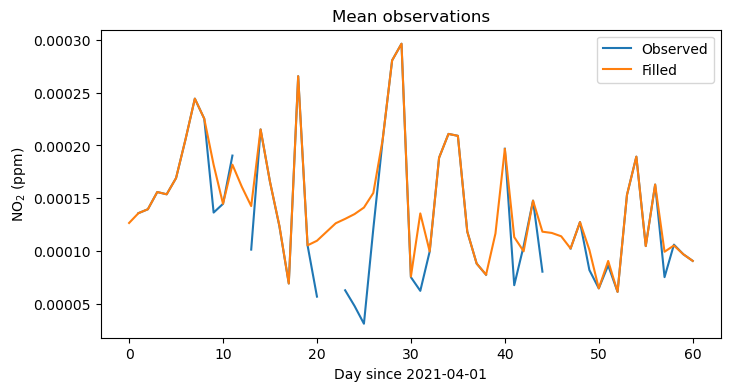

In [13]:
plt.figure(figsize=(8,4))

# Plot observed data
plt.plot(np.nanmean(observed_data.reshape(observed_data.shape[0],-1),axis=1), label="Observed")

# Plot filled data
plt.plot(np.nanmean(filled_data[1:].reshape(observed_data.shape[0],-1),axis=1), label="Filled")

plt.title("Mean observations")
plt.ylabel("NO$_2$ (ppm)")
plt.xlabel("Day since 2021-04-01")
plt.legend()
plt.show()

Therefore, it is noticeable that the gaps observed in the original observations have been successfully filled. Furthermore, the model effectively preserves the overall trend of the observations with smoothening due to the nature of lowess function.
